# Final Project: Cartoonize images

Sélim JOMAA & Eve JOUNI

First, we start by importing the different library that we will need to build the code :

*   cv2 : read, transform and manipulate the images
*   numpy : manipulate the image's data by clustering
*   scipy : analytical analysis
*   collections : to manage the pixels
*   matplotlib : to visualize our images and compare our results






In [64]:
import cv2
import numpy as np
from scipy import stats
from collections import defaultdict
import matplotlib.pyplot as plt

The update_c function :

*   Each intentisity, which is here the pixels color value, is compared to the center of the clusters and assigned to the closer one.
*   The centers are updated by doing the mean of the different intensity assigned to this cluster, until it treat all the intensity.
*  Once it's done, it reduce the number of course by regrouping the similar intensity into smaller clusters.

**Here the main goal is to achieve a more "cartoon" style by regrouping colors to make it less detailled and more uniform.**



In [65]:
def update_c(C, hist):
    while True:
        groups = defaultdict(list)

        for i in range(len(hist)):
            if hist[i] == 0:
                continue
            d = np.abs(C - i)
            index = np.argmin(d)
            groups[index].append(i)

        new_C = np.array(C)
        for i, indices in groups.items():
            if np.sum(hist[indices]) == 0:
                continue
            new_C[i] = int(np.sum(indices * hist[indices]) / np.sum(hist[indices]))

        if np.sum(new_C - C) == 0:
            break
        C = new_C

    return C, groups

The K_histogram function :


*   The function take an initial center, here equal to 128 and a hist distribution.
*   It use the previous function to update the cluster centers.
*   The smallest clusters are not modified.
*   The biggest clusters are tested to see if they are normalized. If they are not, they will be split in two.

**The main goal is to optimize and refine the color clusters to simplify the color palette, to amplify the "cartoon" effect**

In [66]:
def K_histogram(hist, initial_C=128, alpha=0.001, N=80):
    C = np.array([initial_C])

    while True:
        C, groups = update_c(C, hist)

        new_C = set()
        for i, indices in groups.items():
            if len(indices) < N:
                new_C.add(C[i])
                continue

            z, pval = stats.normaltest(hist[indices])
            if pval < alpha:
                left = 0 if i == 0 else C[i - 1]
                right = len(hist) - 1 if i == len(C) - 1 else C[i + 1]
                delta = right - left
                if delta >= 3:
                    c1 = (C[i] + left) / 2
                    c2 = (C[i] + right) / 2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    new_C.add(C[i])
            else:
                new_C.add(C[i])
        if len(new_C) == len(C):
            break
        else:
            C = np.array(sorted(new_C))
    return C

The cartoonize function :


*  We initalize the kernel that will be used later to adjust the contour, and the input image and her size.
*  A bilateral filter is applied for each R, G, B canals to reduce the noises while keeping the contours and smoothing the image.
*  The cv2.canny will detect the contour and generated an image that will be used to add the contour on the cartoonized image.
*  The RGB is converted to HSV, that will be calculted with the hist to extract the distribution of colors.
* the K_histogram will, for each canals of the HSV, reduce the number of colors by optimizing the center of the colors and regrouping the similar ones.
* The image is rebuild in 1D for each canals, then in 3D and converted in RGB again.
* The contour detected previously will be drawed and adapted.
* It also add a blur to make it more cartoon.

**The main goal is to set up the parameters that will transform the initial image into a cartoon style image.**


In [67]:
def cartoonize(img, config):
    kernel = np.ones(config['erosion_kernel_size'], np.uint8)
    output = np.array(img)
    x, y, c = output.shape

    for i in range(c):
        output[:, :, i] = cv2.bilateralFilter(output[:, :, i],
                                              config['bilateral_filter_d'],
                                              config['sigmaColor'],
                                              config['sigmaSpace'])

    edge = cv2.Canny(output, config['canny_threshold1'], config['canny_threshold2'])

    output = cv2.cvtColor(output, cv2.COLOR_RGB2HSV)
    hists = []
    hist, _ = np.histogram(output[:, :, 0], bins=np.arange(180 + 1))
    hists.append(hist)
    hist, _ = np.histogram(output[:, :, 1], bins=np.arange(256 + 1))
    hists.append(hist)
    hist, _ = np.histogram(output[:, :, 2], bins=np.arange(256 + 1))
    hists.append(hist)

    C = []
    for h in hists:
        C.append(K_histogram(h, initial_C=config['initial_C']))

    output = output.reshape((-1, c))
    for i in range(c):
        channel = output[:, i]
        index = np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:, i] = C[i][index]
    output = output.reshape((x, y, c))
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(output, contours, -1, 0, thickness=config['contour_thickness'])

    for i in range(3):
        output[:, :, i] = cv2.erode(output[:, :, i], kernel, iterations=config['erosion_iterations'])

    if config['apply_blur']:
        output = cv2.GaussianBlur(output, config['blur_kernel'], 0)

    return output

The display_images function :


*   This function simply use matplotlib to visualize the inital and cartooned image next to each others to compare them.




In [68]:
def display_images(original, cartoon, figsize=(10, 5)):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(cartoon)
    plt.title("Cartoonized Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### The parameters :

In the base_config dictionnary, we have the different parameters of the cartoonize function thar are set as they are initaly in the git hub code.



***'bilateral_filter_d'*** : Size of the neighborhood for the bilateral filter, controlling the amount of smoothing while preserving edges. Here at 5.

***'sigmaColor'***: For color space, control sensitivity to color variation in the neighborhood, here at 150.

***'sigmaSpace'***: For spatial space, control sensitivity to the distance between neighboring pixels, here at 150.

***'canny_threshold1'***: Lower threshold for edge detection using the canny algorithm. Here at 100.

***'canny_threshold2'***: Upper threshold for edge detection using the canny algorithm, here at 200.

***'initial_C'***: Initial value for color segmentation use by K_histogram, here at 128.

***'erosion_kernel_size'***: Size of the kernel used for erosion, adjusting the strength of the contour refinement effect, hare at (2, 2).

***'erosion_iterations'***: Number of iterations for erosion, determining the strength of contour refinement, here at 1.

***'contour_thickness'***: Thickness of the contours drawn around the areas detected by Canny, here at 1.

***'apply_blur'***: Boolean to enable or disable Gaussian blur on the final image, here at False.

***'blur_kernel'***: Size of the kernel for Gaussian blur, controlling the amount of blur applied to the image, here at (5, 5).






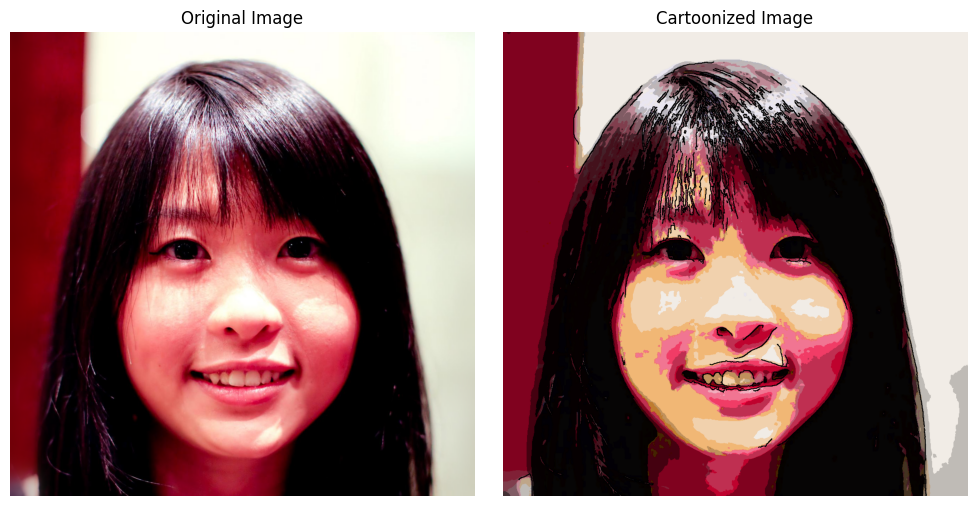

In [71]:
base_config = {
    'bilateral_filter_d': 5,
    'sigmaColor': 150,
    'sigmaSpace': 150,
    'canny_threshold1': 100,
    'canny_threshold2': 200,
    'initial_C': 128,
    'erosion_kernel_size': (2, 2),
    'erosion_iterations': 1,
    'contour_thickness': 1,
    'apply_blur': False,
    'blur_kernel': (5, 5)
}

input_path = "/femme.png"
original = cv2.imread(input_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
cartoon = cartoonize(original, base_config)
display_images(original, cartoon)

The result with those parameters show the cartoonized image on the left. The colors are well mixed but the contour are not very mixed with the rest of the image, which dicrease the cartoon effect.





Now, we are the different parameters to see if the cartoon will increase

- We increase the ***sigmaColor*** and ***sigmaSpace***, that will allow more aggressive and spatial smoothing.

- We set a new ***initial_C*** for the color centers, which could slightly shift the starting point for color segmentation, affecting the final clusters.

- We keep the same strength of contour refinement by not changing the ***eorision_iterations*** and the same thickness of contour by keeping the ***contour_thickness*** at 1.

- We change the ***apply_blur*** at True to softened the image further and reduce sharpness, leading to a smoother, more stylized result.

- We increased the ***blur_kernel*** size for Gaussian blur, resulting in a more significant blur effect, smoothing the image more aggressively.

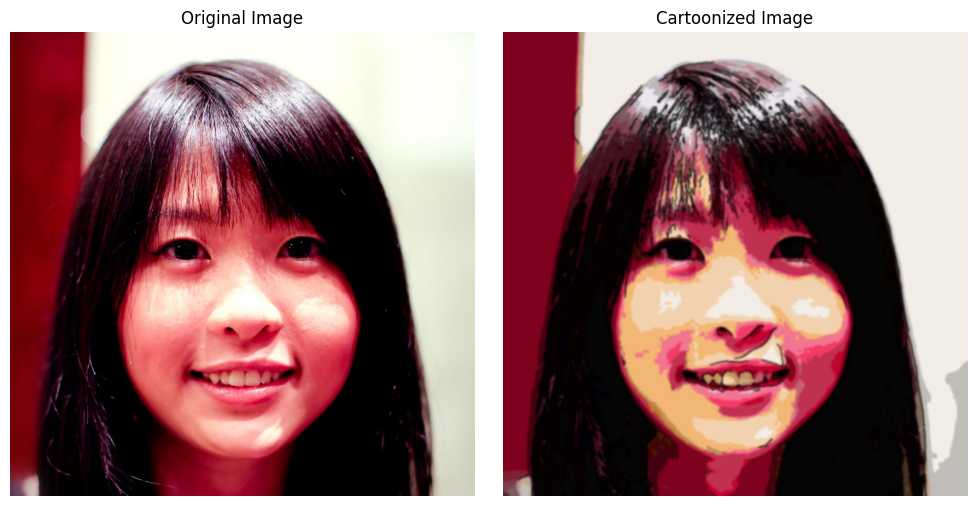

In [72]:

alternative_config = base_config.copy()
alternative_config.update({
    'sigmaColor': 400,
    'sigmaSpace': 400,
    'canny_threshold1': 100,
    'canny_threshold2': 200,
    'initial_C': 120,
    'erosion_iterations': 1,
    'contour_thickness': 1,
    'apply_blur': True,
    'blur_kernel': (11, 11)
})

# Lecture et cartoonisation
input_path = "/femme.png"
original = cv2.imread(input_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
cartoon = cartoonize(original, alternative_config)
display_images(original, cartoon)

Here, we can see that the image is way more smoother, increasing the cartoon style.